# 1. Download dataset

In [ ]:
# Download ICDAR 2003 dataset
# !gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
!unzip -q icdar2003.zip -d datasets

# 2. Install required libraries

In [ ]:
import os
import random
import time
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms
from modules.dataset_processor import OCRDatasetProcessor, STRDataset
from modules.models import CRNNTrainer

# 3. Extract and Store Data

In [ ]:
processor = OCRDatasetProcessor(blank_char='-')

In [ ]:
dataset_dir = "datasets/SceneTrialTrain"
img_paths, img_sizes, img_labels, bboxes = processor.extract_data_from_xml(dataset_dir)

print(f"Total images: {len(img_paths)}")
print(f"Total bounding boxes: {sum([len(bbs) for bbs in bboxes])}")

Total images: 250
Total bounding boxes: 1097


In [ ]:
i = random.randint(0, len(img_paths))
processor.plot_image_with_bbs(img_paths[i], bboxes[i], img_labels[i])

In [ ]:
save_dir = "datasets/ocr_dataset"
processor.split_bounding_boxes(img_paths, img_labels, bboxes, save_dir)

Created 1088 images


# 4. Read dataset

In [9]:
root_dir = save_dir

img_paths = []
labels = []

# Read labels from text file
with open(os.path.join(root_dir, "labels.txt"), "r") as f:
    for label in f:
        labels.append(label.strip().split("\t")[1])
        img_paths.append(label.strip().split("\t")[0])

print(f"Total images: {len(img_paths)}")

Total images: 1088


# 5. Prepare vocabulary

In [10]:
letters = [char.split(".")[0].lower() for char in labels]
letters = "".join(letters)
letters = sorted(list(set(list(letters))))

# create a string of all characters in the dataset
chars = "".join(letters)

# for "blank" character
blank_char = "-"
chars += blank_char
vocab_size = len(chars)

print(f"Vocab: {chars}")
print(f"Vocab size: {vocab_size}")

Vocab: 0123456789abcdefghijklmnopqrstuvwxyz-
Vocab size: 37


In [ ]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
max_label_len = max([len(label) for label in labels])

processor.decode([torch.tensor([20, 30, 1, 20, 20, 1])], idx_to_char)

['isi']

# 6. Data Augmentation

In [16]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(
                brightness=0.5,
                contrast=0.5,
                saturation=0.5,
            ),
            transforms.Grayscale(
                num_output_channels=1,
            ),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(
                degrees=1,
                shear=1,
            ),
            transforms.RandomPerspective(
                distortion_scale=0.3,
                p=0.5,
                interpolation=3,
            ),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

# 7. Train, val, test split

In [17]:
seed = 0
val_size = 0.1
test_size = 0.1
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths,
    labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

# 8. Create dataloader

In [ ]:
train_dataset = STRDataset(
    X_train,
    y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=processor.encode,
    transform=data_transforms["train"],
)
val_dataset = STRDataset(
    X_val,
    y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=processor.encode,
    transform=data_transforms["val"],
)
test_dataset = STRDataset(
    X_test,
    y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=processor.encode,
    transform=data_transforms["val"],
)

In [20]:
print(
    f"Train dataset: {len(train_dataset)}",
    f"Val dataset: {len(val_dataset)}",
    f"Test dataset: {len(test_dataset)}",
    sep="\n",
)

Train dataset: 881
Val dataset: 109
Test dataset: 98


In [21]:
train_batch_size = 64
test_batch_size = 64 * 2

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

['clacton', 'nuisance', 'handle', 'campbel', 'hofman', '3', 'raised', 'of', 'please', 'yarmouth', 'fod', 'and', 'but', 'toyota', 'mouth', '2a', '13', 'website', 'in', 'coling', 'national', 'hardware', 'e', 'systems', 'just', 't', 'series', 'information', 'causing', 'services', 'eir', 'mason', 'dental', 'washing', 'edition', 'e', 'hygiene', 'fotpath', 'give', 'castle', 'order', 'care', 'break', 'farnborough', '17', 'car', 'animal', 'h', 'a', 'stop', 'scenes', 'asociates', '201', 'discover', 'ofice', 'the', 'computing', 'lion', 'ian', 'beardwel', 'conviction', 'of', 'agents', 'the']


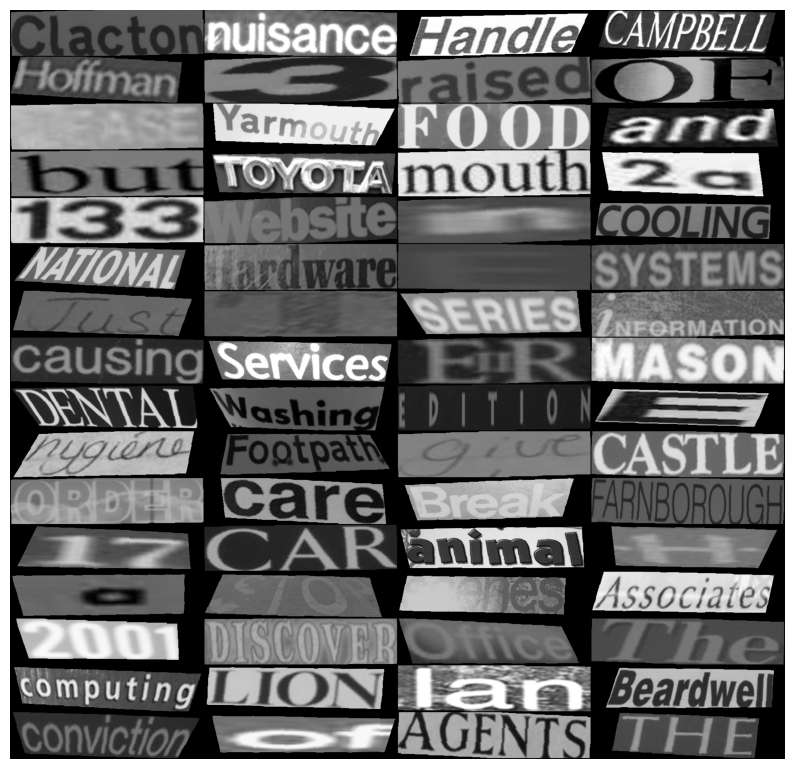

In [ ]:
train_features, train_labels, train_lengths = next(iter(train_loader))


# use torchvision to display a grid of images
def show_batch(imgs, labels):
    labels = processor.decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    print(labels)
    plt.show()


show_batch(train_features, train_labels)

# 9. Create model

In [ ]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CRNNTrainer(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers,
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
model.eval()

dummy_tensor = torch.rand((64, 1, 100, 420)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print("Output shape:", output.shape)

Output shape: torch.Size([14, 64, 37])


# 10. Training

In [28]:
epochs = 100
lr = 1e-3
weight_decay = 1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True,
    reduction="mean",
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=0.1
)

In [ ]:
train_losses, val_losses = model.fit(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs
)

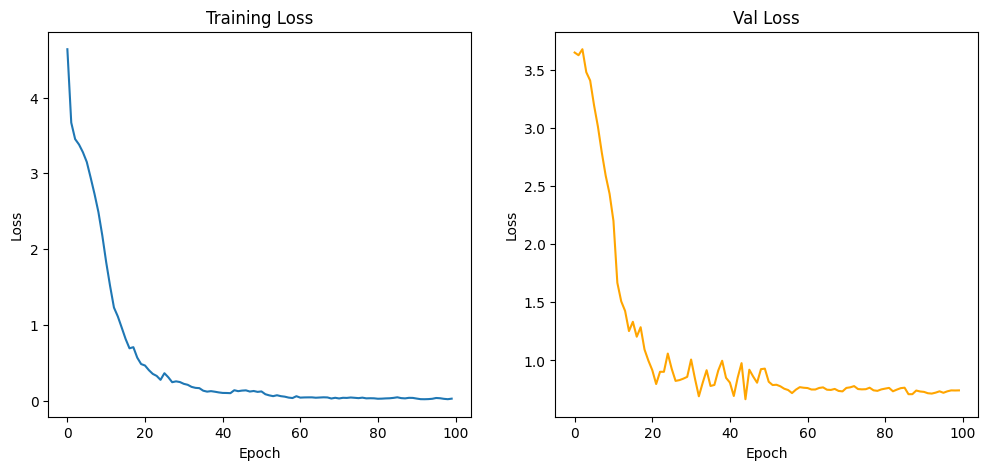

In [ ]:
model.show_stats()

# 11. Evaluation

In [ ]:
val_loss = model.evaluate(model, val_loader, criterion, device)
test_loss = model.evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print("Val loss: ", val_loss)
print("Test loss: ", test_loss)

Evaluation on val/test dataset
Val loss:  0.7424494028091431
Test loss:  1.2967315912246704


# 12. Make Predictions with PostProcessing

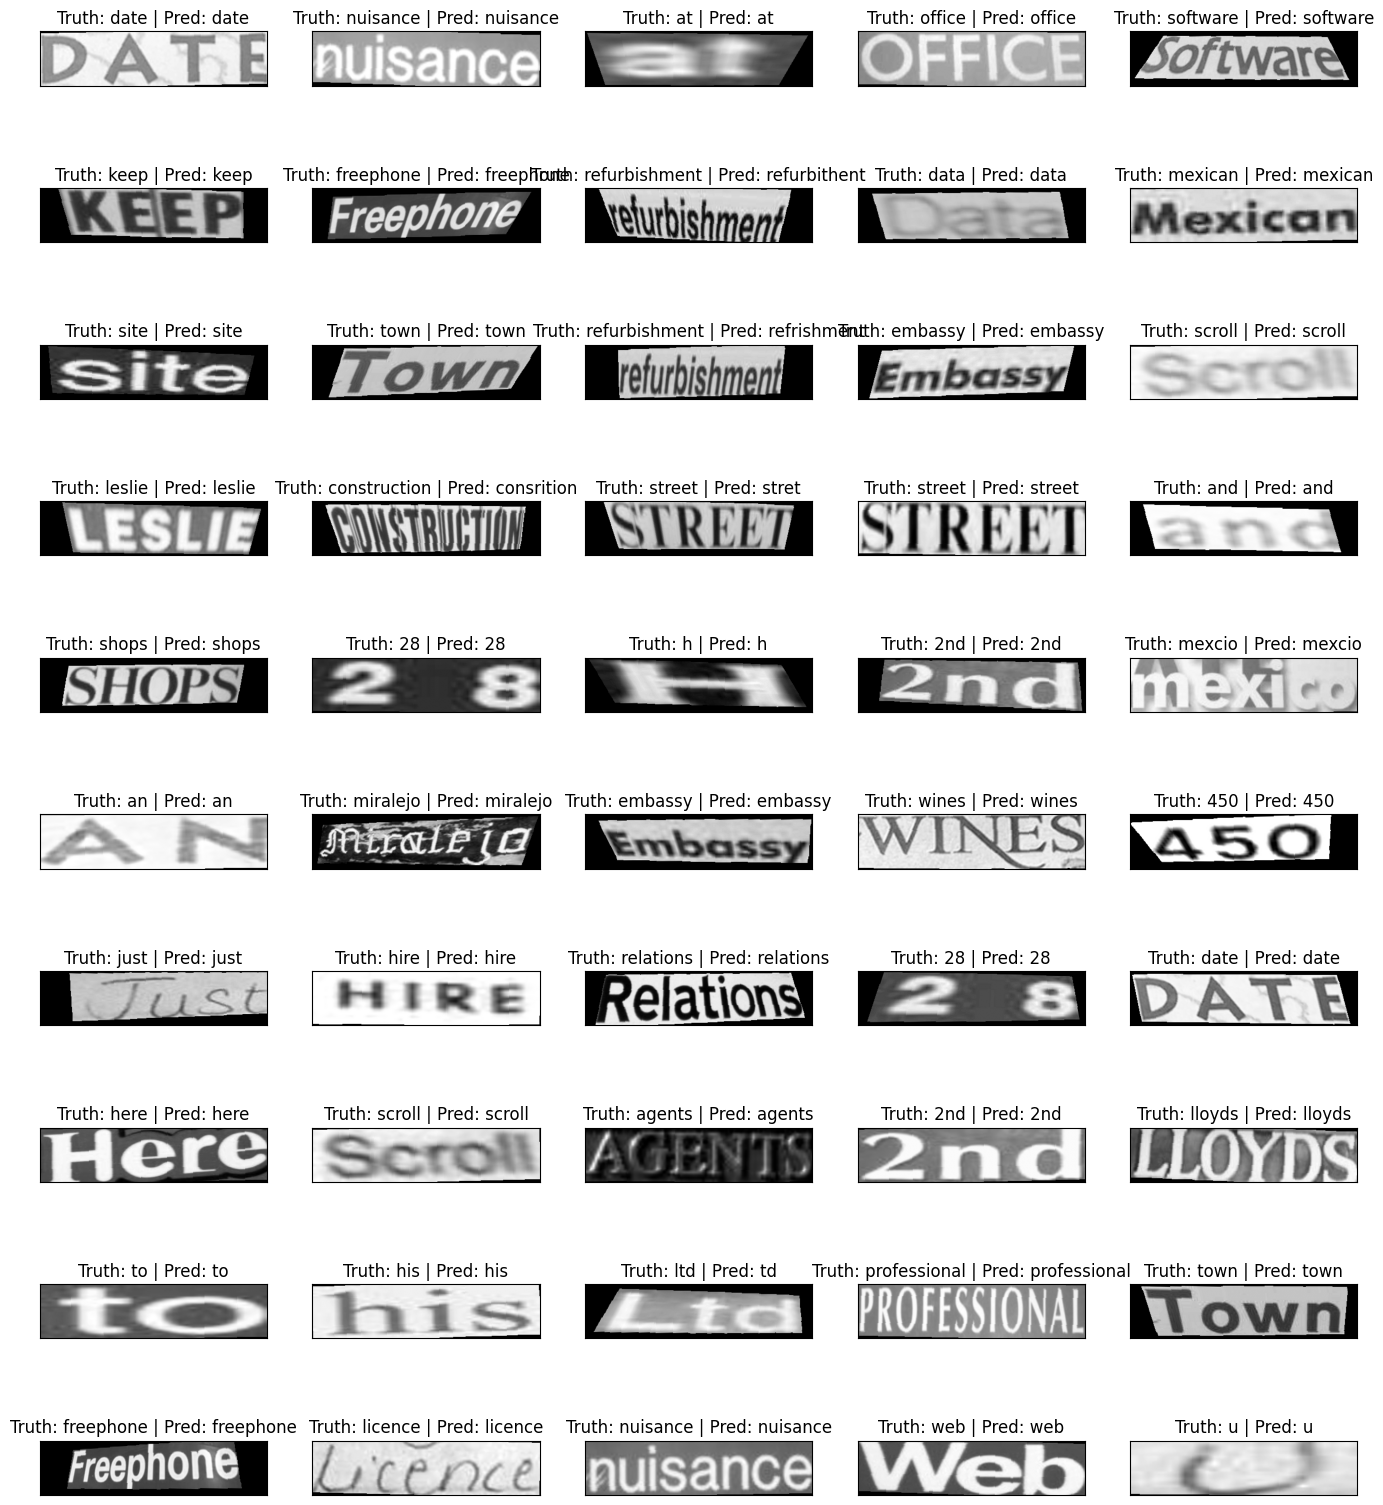

In [ ]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = model.decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = model.decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

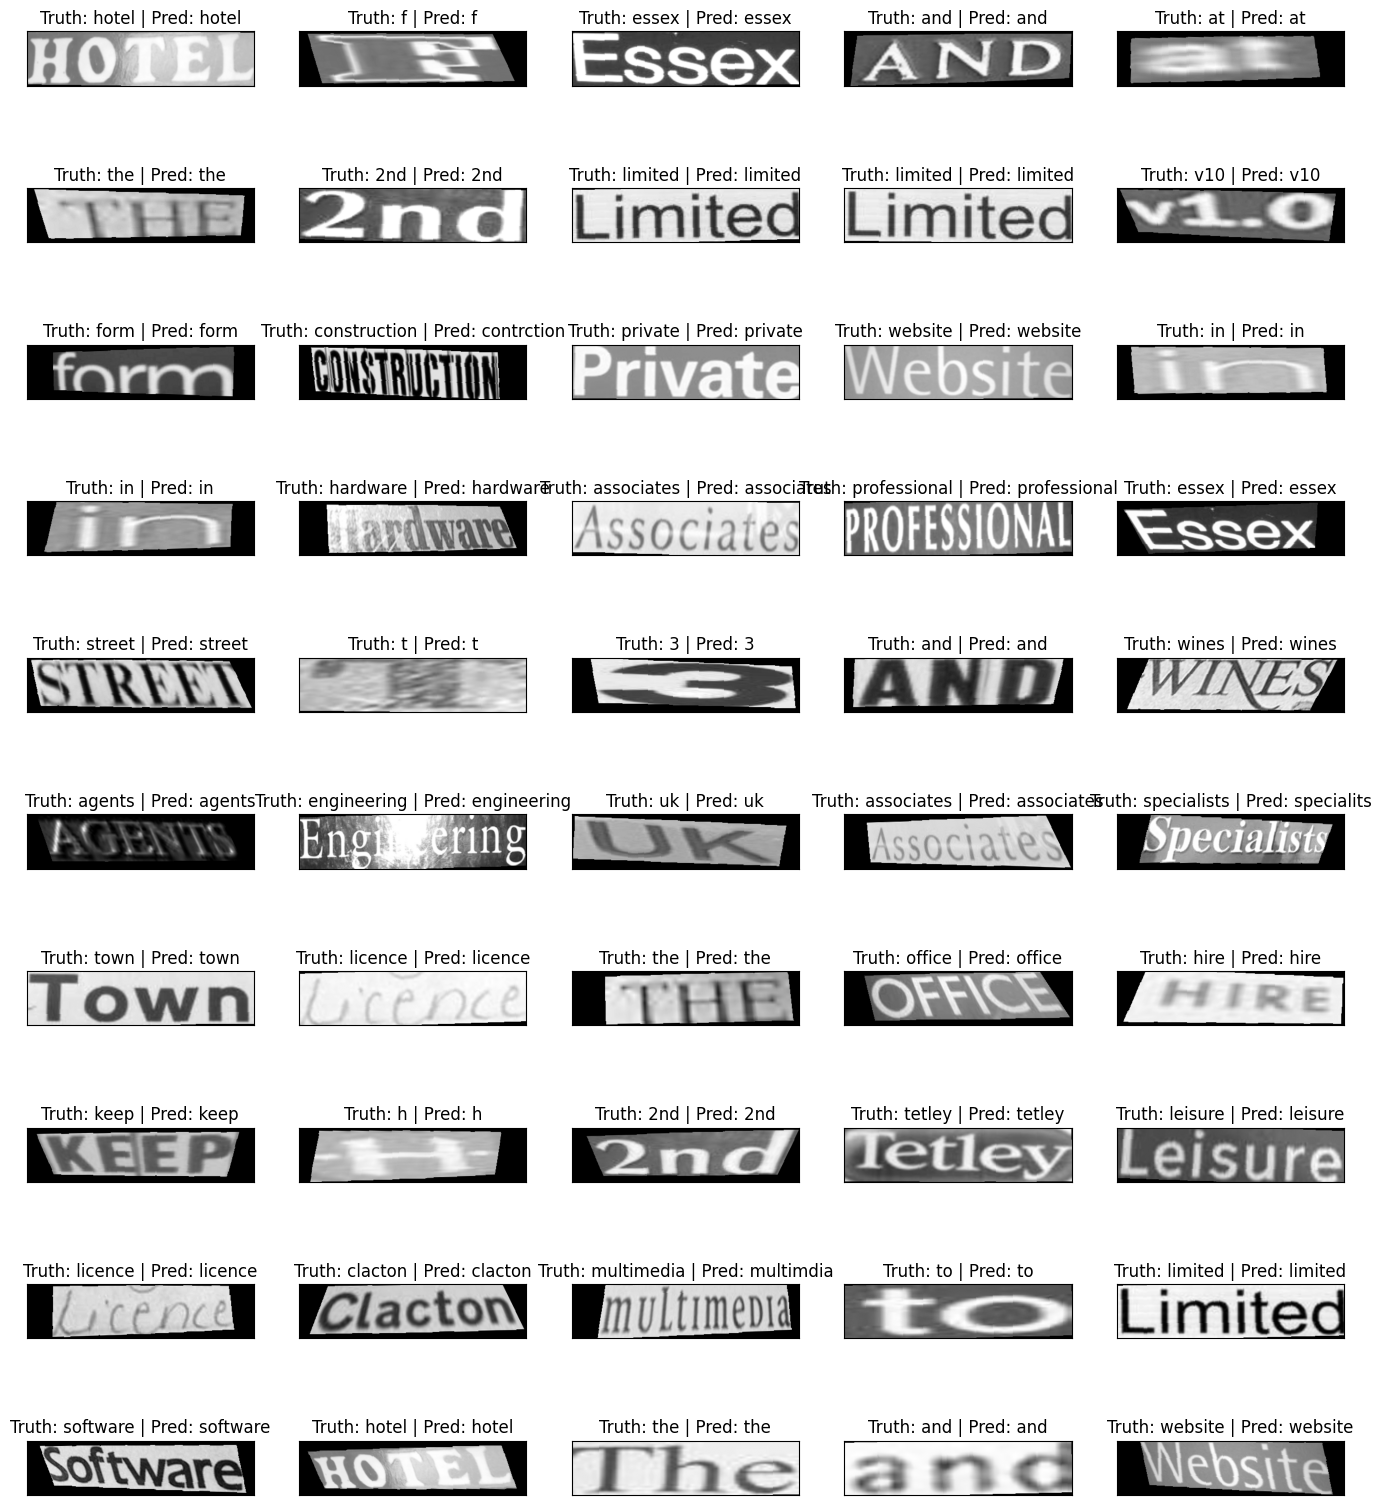

In [ ]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = train_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = model.decode_label([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = processor.decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

# 13. Save model

In [35]:
save_model_path = "ocr_crnn.pt"
torch.save(model.state_dict(), save_model_path)